# **Subwords preprocessing**

Subwords are another approach, where individual words are broken up into the more commonly appearing pieces of themselves. This helps avoid marking very rare words as OOV for the most common words in a corpus.

Subwords are made up of pieces of words, so that words with similar roots will be tokenized to have at least partially the same value. So, words like “famous” and “famously” might be tokenized similarly, with perhaps an extra subword at the end for the “-ly”.

In [21]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_datasets as tfds

In [3]:
dataset = pd.read_csv('combined_data.csv')

# Just extract out sentences and labels first - we will create subwords here
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

sentences[:10]

['So there is no way for me to plug it in here in the US unless I go by a converter.',
 'Good case Excellent value.',
 'Great for the jawbone.',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!',
 'The mic is great.',
 'I have to jiggle the plug to get it to line up right to get decent volume.',
 'If you have several dozen or several hundred contacts then imagine the fun of sending each of them one by one.',
 'If you are Razr owner...you must have this!',
 'Needless to say I wasted my money.',
 'What a waste of money and time!.']

## **Create a subwords dataset**

We also can use the existing Amazon and Yelp reviews dataset with `tensorflow_datasets`'s `SubwordTextEncoder` functionality. `SubwordTextEncoder.build_from_corpus()` will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

In [6]:
vocab_size = 1000
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

In [7]:
tokenizer

<SubwordTextEncoder vocab_size=999>

In [8]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])

I have to jiggle the plug to get it to line up right to get decent volume.


In [9]:
encoded = tokenizer.encode(sentences[num])
print(encoded)

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [10]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


In [14]:
# Replace sentence data with encoded subwords
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [17]:
# Check the sentences are appropriately replaced
print(sentences[:10])

[[736, 168, 775, 7, 193, 417, 17, 94, 6, 600, 438, 775, 14, 19, 141, 19, 1, 828, 826, 775, 99, 445, 4, 174, 361, 5, 79, 227, 139, 789], [625, 677, 626, 274, 380, 633, 148, 844, 789], [134, 775, 17, 1, 849, 179, 205, 52, 789], [827, 187, 11, 6, 143, 63, 17, 79, 227, 594, 331, 3, 660, 26, 313, 182, 795, 415, 374, 60, 789, 820, 808, 817, 822, 825, 775, 823, 825, 822, 809, 819, 812, 820, 826, 263], [13, 396, 570, 7, 35, 789], [4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789], [364, 39, 31, 69, 500, 775, 197, 293, 38, 117, 69, 500, 775, 399, 123, 475, 775, 79, 62, 86, 3, 506, 241, 683, 557, 775, 1, 429, 38, 15, 69, 123, 26, 210, 232, 15, 507, 80, 361, 478, 789], [364, 39, 41, 825, 840, 865, 20, 280, 444, 465, 39, 602, 8, 31, 505, 858, 776], [821, 359, 843, 445, 6, 472, 4, 584, 11, 21, 395, 789], [384, 48, 5, 584, 775, 15, 395, 775, 2, 640, 262]]


In [18]:
max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [19]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [20]:
num_epochs = 50
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/50
50/50 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5009 - val_loss: 0.6946 - val_accuracy: 0.4135
Epoch 2/50
50/50 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5292 - val_loss: 0.6963 - val_accuracy: 0.4261
Epoch 3/50
50/50 [==============================] - 0s 4ms/step - loss: 0.6862 - accuracy: 0.5681 - val_loss: 0.6921 - val_accuracy: 0.5013
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.6771 - accuracy: 0.6083 - val_loss: 0.6826 - val_accuracy: 0.5589
Epoch 5/50
50/50 [==============================] - 0s 4ms/step - loss: 0.6621 - accuracy: 0.6899 - val_loss: 0.6673 - val_accuracy: 0.6516
Epoch 6/50
50/50 [==============================] - 0s 4ms/step - loss: 0.6386 - accuracy: 0.7514 - val_loss: 0.6541 - val_accuracy: 0.6441
Epoch 7/50
50/50 [==============================] - 0s 4ms/step - loss: 0.6098 - accuracy: 0.7721 - val_loss: 0.6267 - val_accuracy: 0.7193
Epoch 8/50
50/50 [==

In [22]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

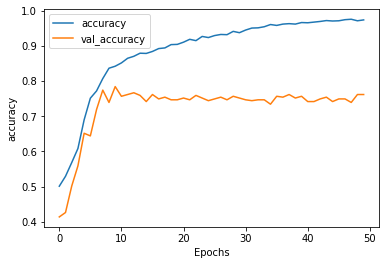

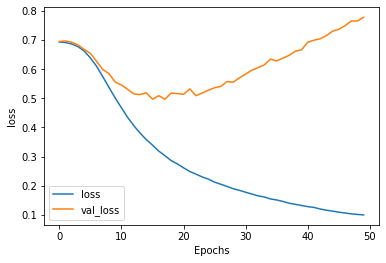

In [24]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# **Visualizing the network**

In [25]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [26]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('subword_vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('subword_meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [28]:
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('subword_vecs.tsv')
  files.download('subword_meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>